# Compute vibrational energies of OCS using variational method

- Expand vibrational wavefunctions in linear combination of products of one-dimensional basis functions for each vibrational coordinate:
  $$ \Psi_l(x_1,x_2,x_3) = \sum_{i,j,k} c_{i,j,k}^{(l)}\phi_i^{(1)}(x_1)\phi_j^{(2)}(x_2)\phi_k^{(3)}(x_3).$$

- Our task is to find the linear expansion coefficients $c_{i,j,k}^{(l)}$ and the corresponding vibrational energies $E_l$ by solving the stationary Schrödinger equation:
  $$(\hat{T}+V)\Psi_l = E_l\Psi_l,$$
  where $V$ is potential energy function for selected electronic state (see [ocs_potential.ipynb](ocs_potential.ipynb))
  and $\hat{T}$ is kinetic energy operator (see [ocs_coordinates.ipynb](ocs_coordinates.ipynb)).

- This is equivalent to solving the eigenvalue problem:

  $$ (\mathbf{T}+\mathbf{V})\mathbf{C} = \mathbf{E}\mathbf{S}\mathbf{C},$$

  where

  $$
  T_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}\hat{T}\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3 =
  -\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}
  \frac{\partial}{\partial x_\lambda}
  G_{\lambda,\mu}\frac{\partial}{\partial x_\mu}
  \phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3,
  $$

  $$V_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3,$$

  and

  $$S_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3.$$

  If the basis is orthonormal, $\mathbf{S}=\mathbf{I}$.

In the following we address two key challenges:
1. selecting the appropriate basis functions for each coordinate, $\phi^{(1)}(x_1)$, $\phi^{(2)}(x_2)$, and $\phi^{(3)}(x_3)$,
2. calculating the corresponding matrix elements, $V_{l',l}$ and $\hat{T}_{l',l}$.

In [33]:
import import_ipynb

In [34]:
from numpy.polynomial.legendre import leggauss, legval, legder
from numpy.polynomial.laguerre import laggauss, lagval, lagder
from numpy.polynomial.hermite import hermgauss, hermval, hermder
import numpy as np
import math
from scipy import constants
import itertools
from typing import Optional, Tuple

from kinetic import Gmat, Gmat_batch
from ocs_coordinates import jacobi_to_cartesian
from ocs_potential import potentials

import jax
from jax import numpy as jnp
from jax import config

config.update("jax_enable_x64", True)

import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Matplotlib settings
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = (8, 6)

# Physics units conversion factors
hartree_to_invcm = constants.value('hartree-inverse meter relationship') / 100

## One-dimensional basis functions and Gaussian quadratures

- Orthogonal polynomials ([Wiki page](https://en.wikipedia.org/wiki/Orthogonal_polynomials)):
$$\int W(x)P_i(x)P_j(x)dx=N_i\delta_{ij}$$

- Examples of classical orthogonal polynomials:

    |Weight function $W(x)$ | Polynomial $P$ | Ranges |
    |:-:|:-:|:-:|
    |$e^{-x^2}$| Hermite | $[-\infty,\infty]$|
    | 1| Legendre | $[-1, 1]$|
    |$e^{-x}$ | Laguerre | $[0, \infty]$ |
    |$\sqrt{1-x^2}$ | Chebyshev | $[-1, 1]$|
    |$(1-x)^\alpha(1+x)^\beta,~\alpha,\beta>-1$| Jacobi | $[-1, 1]$|

- Build basis functions from orthogonal polynomials:
$$\phi_j(x) = \sqrt{W(x)}P_j(x),$$

$$\langle \phi_i|\phi_j\rangle = \int W(x)P_i(x)P_j(x)dx=N_i\delta_{ij}.$$

- Gaussian quadratures for integration ([Wiki page](https://en.wikipedia.org/wiki/Gaussian_quadrature)):

$$\int W(x)f(P(x))dx=\sum_g^{N_g} w_g f(x_g),$$

$$\langle \phi_i|V|\phi_j\rangle = \int W(x)\underbrace{P_i(x)P_j(x)V(x)}_{f(P(x))}dx\approx \sum_g^{N_g} w_g P_i(x_g)P_j(x_g)V(x_g)= \sum_g^{N_g} \frac{w_g}{W(x_g)} \phi_i(x_g)\phi_j(x_g)V(x_g).$$

- The ranges for polynomial functions and associated quadrature coordinates, denoted by $x$,
  may differ from the ranges of physical coordinates, which are the coordinates that the kinetic
  and potential energy operators depend on.
  For example, the range for the $r_\text{S}$ coordinate is $[0,5] , \text{\AA}$,
  whereas the range for Hermite basis functions extends from $[-\infty, \infty]$.
  Therefore, it is necessary to define a coordinate transformation $f_{x\rightarrow r}(x)$ that maps the ranges of quadrature
  coordinates onto the ranges of the physical coordinates, i.e., $r = f_{x\rightarrow r}(x)$.

Here are several examples of classical polynomials (Legendre, $L_n$, Laguerre, $P_n$, Hermite, $H_n$), that we will use as basis functions for the $r_\text{S}$, $r_\text{CO}$, and $\theta$ vibrational Jacobi coordinates:

$$\phi_i^{(1)}(x_1) = e^{-x_1^2/2}H_n(x_1),$$
$$\phi_i^{(2)}(x_2) = e^{-x_2^2/2}H_n(x_2),$$
$$\phi_i^{(3)}(x_3) = L_n(x_3).$$

In [36]:
def legendre(nmax: int, x: np.ndarray) -> np.ndarray:
    """Legendre functions, shape = (nmax, len(x))"""
    c = np.diag([np.sqrt((2 * n + 1) / 2) for n in range(nmax)])
    return legval(x, c)


def legendre_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivates of Legendre functions, shape = (nmax, len(x))"""
    c = np.diag([np.sqrt((2 * n + 1) / 2) for n in range(nmax)])
    return legval(x, legder(c, m=1))


def hermite(nmax: int, x: np.ndarray) -> np.ndarray:
    """Hermite functions, shape = (nmax, len(x))"""
    sqsqpi = np.sqrt(np.sqrt(np.pi))
    c = np.diag(
        [1.0 / np.sqrt(2.0**n * math.factorial(n)) / sqsqpi for n in range(nmax)]
    )
    return hermval(x, c) * np.exp(-(x**2) / 2)


def hermite_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivatives of Hermite functions, shape = (nmax, len(x))"""
    sqsqpi = np.sqrt(np.sqrt(np.pi))
    c = np.diag(
        [1.0 / np.sqrt(2.0**n * math.factorial(n)) / sqsqpi for n in range(nmax)]
    )
    H = hermval(x, c)
    dH = hermval(x, hermder(c, m=1))
    return (dH - H * x) * np.exp(-(x**2) / 2)


def laguerre(nmax: int, x: np.ndarray) -> np.ndarray:
    """Laguerre functions, shape = (nmax, len(x))"""
    c = np.diag([1 for _ in range(nmax)])
    return lagval(x, c) * np.sqrt(x) * np.exp(-x / 2)


def laguerre_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivatives of Laguerre functions, shape = (nmax, len(x))"""
    c = np.diag([1 for _ in range(nmax)])
    L = lagval(x, c)
    dL = lagval(x, lagder(c, m=1))
    return (2 * x * dL + (1 - x) * L) / (2 * x) * np.exp(-x / 2)


For example, `hermgauss(Ng) -> x[Ng], w[Ng]` generates $N_g$ quadrature points $x_g$ and weights $w_g$.

Function `hermite(Nb, x[Ng]) -> phi[Nb, Ng]` generates $N_b$ Hermite functions $e^{-x_g^2/2}H_i(x_g)$ for $i=0..N_B-1$,
and function `hermite_deriv(Nb, x[Ng]) -> dphi[Nb, Ng]` generates derivatives of Hermite functions.

The computation of a one-dimensional integral of an operator between basis functions, for example, overlap 
$$S_{i,j} = \int \phi_{i}(x)\phi_{j}(x)dx\approx \sum_g \frac{w_g}{W(x_g)}\phi_{i}(x_g)\phi_{j}(x_g),$$
can be casted as following
`S = np.einsum('ig,jg,g->ij', phi, phi, w/np.exp(-x**2/2))`

check orthonormality, max(|S-I|): 3.9968028886505635e-15
check orthonormality, max(|S-I|): 3.9968028886505635e-15
check orthonormality, max(|S-I|): 4.0745185003743245e-14


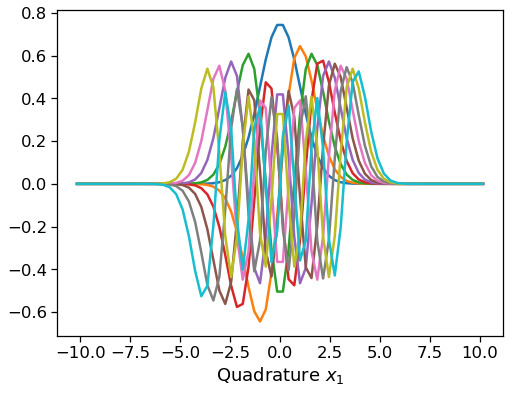

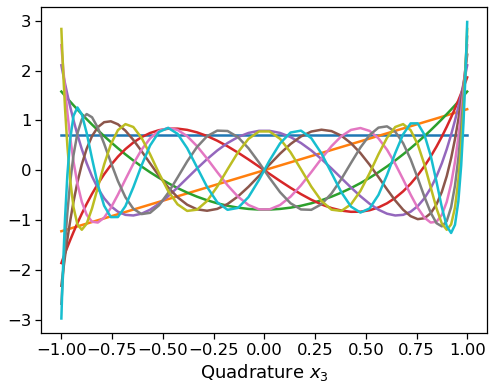

In [37]:
# number of basis functions for different coordinates
Nb1 = 40
Nb2 = 40
Nb3 = 40

# number of Gaussian quadrature points for different coordinates
Ng1 = 60
Ng2 = 60
Ng3 = 60

# Hermite quadrature and functions for r_S coordinate
x1, w1 = hermgauss(Ng1)
w1 /= np.exp(-x1**2)
phi1 = hermite(Nb1, x1)

S = np.einsum("ig,jg,g->ij", phi1, phi1, w1)
print("check orthonormality, max(|S-I|):", np.max(np.abs(S - np.eye(Nb1))))


# Hermite quadrature and functions for r_{CO} coordinate
x2, w2 = hermgauss(Ng2)
w2 /= np.exp(-x2**2)
phi2 = hermite(Nb2, x2)

S = np.einsum("ig,jg,g->ij", phi2, phi2, w2)
print("check orthonormality, max(|S-I|):", np.max(np.abs(S - np.eye(Nb2))))


# Legendre quadrature/functions for theta coordinate
x3, w3 = leggauss(Ng3)
phi3 = legendre(Nb3, x3)

S = np.einsum("ig,jg,g->ij", phi3, phi3, w3)
print("check orthonormality, max(|S-I|):", np.max(np.abs(S - np.eye(Nb3))))

# plot basis functions

plt.plot(x1, phi1[:10].T)
# plt.xlim([0, 100])
plt.xlabel("Quadrature $x_1$")
plt.show()

plt.plot(x3, phi3[:10].T)
plt.xlabel("Quadrature $x_3$")
plt.show()

We can now define 1D basis functions for different coordinates and their derivatives,
e.g., `func_phi1(x1)` $\rightarrow \phi_i^{(1)}(x_1)$, `func_dphi1(x1)` $\rightarrow d\phi_i^{(1)}(x_1)/dx_1$.

In [38]:
func_phi1 = lambda x: hermite(Nb1, x)
func_phi2 = lambda x: hermite(Nb2, x)
func_phi3 = lambda x: legendre(Nb3, x)

func_dphi1 = lambda x: hermite_deriv(Nb1, x)
func_dphi2 = lambda x: hermite_deriv(Nb2, x)
func_dphi3 = lambda x: legendre_deriv(Nb3, x)

# check that functions work, e.g., check orthonormality
S = np.einsum('ig,jg,g->ij', func_phi1(x1), func_phi1(x1), w1)
print("check orthonormality for coo 1, max(|S-I|):", np.max(np.abs(S - np.eye(Nb1))))

check orthonormality for coo 1, max(|S-I|): 3.9968028886505635e-15


## Map physical coordinates into quadrature points

You may have noticed that the ranges for the quadrature coordinates $x_1$, $x_2$, and $x_3$ dont' align well with the physical coordinate ranges for $r_\text{S}$, $r_\text{CO}$, and $\theta$.

For example, print min and max values of quadrature coordinates and compare them with min and max values of Jacobi coordinates used to represent the PES for the ground electronic state of OCS.

In [39]:
xmin = np.min([x1, x2, x3], axis=-1)
xmax = np.max([x1, x2, x3], axis=-1)

rmin = potentials[0].min
rmax = potentials[0].max

for icoo in range(3):
    print(f"\nx{icoo}: [{xmin[icoo].round(4)}, {xmax[icoo].round(4)}]")
    print(f"r{icoo}: [{rmin[icoo].round(4)}, {rmax[icoo].round(4)}]")


x0: [-10.1591, 10.1591]
r0: [1.8521, 2.6459]

x1: [-10.1591, 10.1591]
r1: [0.9525, 1.3759]

x2: [-0.9992, 0.9992]
r2: [0.0175, 1.0472]


Therefore, it's essential to apply a transformation $f_{x\rightarrow r}$ that maps the physical coordinates' range accurately onto the quadrature grids.

- For Hermite basis functions, we know that they are used to represent solutions of the quantum harmonic oscillator problem, with the Hamiltonian:
  $$ \hat{H} = -\frac{1}{2}\left(\frac{1}{m}\right)\nabla_r^2 + \frac{1}{2}m\omega r^2.$$
  and solutions ([Wiki page](https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator)):
  $$ \psi_n(r) = \sqrt{\frac{1}{2^nn!\sqrt{\pi}}} (m\omega)^{1/4} e^{-m\omega r^2/2} H_n(\sqrt{m\omega}r), $$
  which align with our representation of Hermite basis functions when 
  $$x = \sqrt{m\omega}r = \alpha r.$$

- By comparing our vibrational Hamiltonian with harmonic oscillator, we can obtain the coordinate scaling parameter $\alpha$:
  $$ \hat{H} = -\frac{1}{2}G \nabla_r^2 + V~~~\rightarrow~~~m=1/G,~m\omega^2 = \frac{\partial^2 V}{\partial r^2},~\frac{\partial V}{\partial r}=0, $$
  and 
  $$\alpha=\sqrt{m\omega}=\sqrt{\sqrt{\frac{\partial^2V}{\partial r^2}\frac{1}{G}}}.$$

- Further, we whant to map the center of the quadrature $x$ (placed at zero) to the equilibrium value of physical coordinate (at $r_\text{eq}$):
  $$x = \alpha (r-r_\text{eq}).$$

- For Legendre basis functions, we can map the quadrature range $[-1,1]$ into the range $[0,\pi]$ for the angular coordinate $\theta$ as
  $$x=\cos(\theta).$$

The coordinate mapping $r=f_{x\rightarrow r}(x)$ is implemented in function `map_x_to_r` (and its vectorised version `map_x_to_r_batch`),
and the Jacobial of the coordinate transformation $\nabla_x f_{x\rightarrow r}$ is implemented in function `jac_x_to_r`.

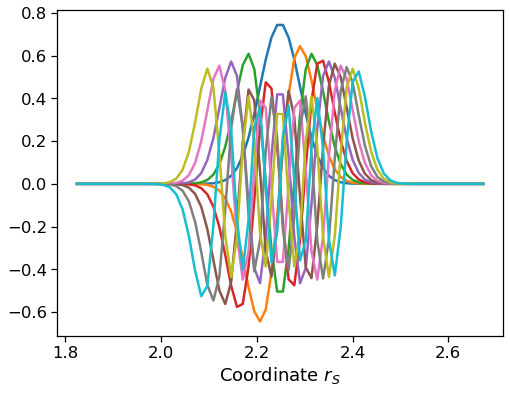

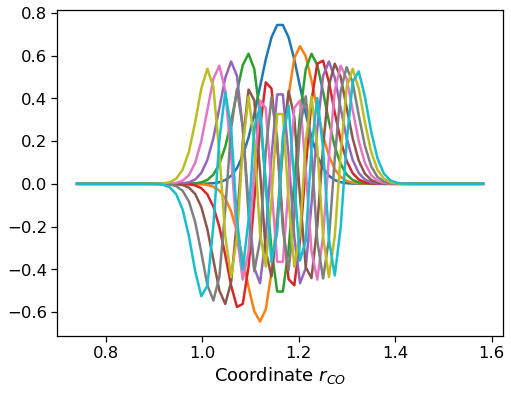

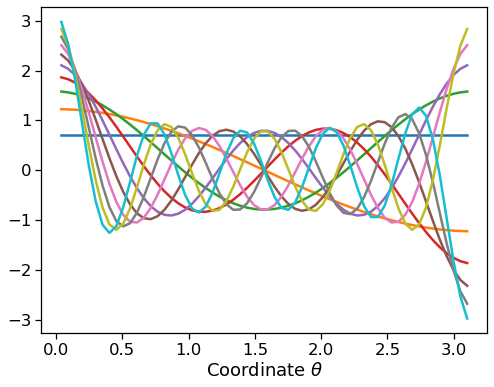

In [40]:
# serial version of mapping function
def map_x_to_r(x, r_eq, poten_deriv2, gmat_diag):
    alpha = jnp.sqrt(jnp.sqrt(2 * poten_deriv2 / gmat_diag))
    return jnp.array(
        [
            x[0] / alpha[0] + r_eq[0],
            x[1] / alpha[1] + r_eq[1],
            jnp.arccos(x[2]),
        ]
    )


# vectorised version of `x_to_r`
map_x_to_r_batch = jax.jit(jax.vmap(map_x_to_r, in_axes=(0, None, None, None)))

# jacobian of the x -> r transformation, dr/dx
jac_x_to_r = jax.vmap(jax.jacrev(map_x_to_r, argnums=0), in_axes=(0, None, None, None))

# PES equilibrium
r_eq = potentials[1].eq

# PES second-order derivative for each coordinate at equilibrium
poten_deriv2 = potentials[1].deriv2 * hartree_to_invcm

# diagonal elements of G matrix
gmat_diag = np.diag(Gmat(r_eq, jacobi_to_cartesian)[:3, :3])

# compute physical coordiantes from quadratures
r1, r2, r3 = map_x_to_r([x1, x2, x3], r_eq, poten_deriv2, gmat_diag)

# plot basis functions

plt.plot(r1, phi1[:10].T)
plt.xlabel("Coordinate $r_S$")
plt.show()

plt.plot(r2, phi2[:10].T)
plt.xlabel("Coordinate $r_{CO}$")
plt.show()

plt.plot(r3, phi3[:10].T)
plt.xlabel("Coordinate $\\theta$")
plt.show()

## Build direct-product basis set and matrix elements

- Our task is to compute matrix elements (integrals), like, for example, of the potential energy operator:
  $$V_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dr_\text{S}dr_\text{CO}dr_\theta,
  $$
  
  which can be approximated using Gaussian quadratures for each vibrational coordinate, as
  $$V_{l',l}\approx
  \sum_f^{N_f} \sum_g^{N_g}\sum_h^{N_h}w_f^{(1)}w_g^{(2)}w_h^{(3)}
  \phi_{i'}^{(1*)}(x_f^{(1)})\phi_{j'}^{(2*)}(x_g^{(2)})\phi_{k'}^{(3*)}(x_h^{(3)})
  V\left(f_{x\rightarrow r}(x_f^{(1)}, x_g^{(2)}, x_h^{(3)})\right)
  \phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)}).
  $$
- Introduce a multi-index for combinations of quantum numbers $l=\{i,j,k\}$, $l'=\{i',j',k'\}$ and quadrature points $p=\{f,g,h\}$, such that
  $$x_p=(x_f^{(1)},x_g^{(2)}, x_h^{(3)}),$$
  $$w_p = w_f^{(1)}w_g^{(2)}w_h^{(3)},$$
  $$\Phi_l(x_p)=\phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)}).$$

- The matrix elements of potential can now be expressed in a compact form
  $$V_{l',l}=\sum_p w_p \Phi_{l'}^*(x_p)V(f_{x\rightarrow r}(x_p)) \Phi_l(x_p).
  $$

- A similar compact expression for the matrix elements of kinetic energy operator can be obtained as
  $$
  T_{l',l}=-\frac{1}{2}\sum_{\lambda,\mu\in \{r_\text{S}, r_\text{CO}, \theta\}}\sum_p w_p
  \Phi_{l'}^*(x_p)\frac{\partial}{\partial r_\lambda}
  G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
  \frac{\partial}{\partial r_\mu} \Phi_l(x_p) = \\
  =\frac{1}{2}\sum_{\lambda,\mu\in \{r_\text{S}, r_\text{CO}, \theta\}}\sum_p w_p
  \frac{\partial\Phi_{l'}^*(x_p)}{\partial r_\lambda}
  G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
  \frac{\partial\Phi_l(x_p)}{\partial r_\mu}.
  $$
  
  $$
  \frac{\partial\Phi_l(x_p)}{\partial r_\mu} =
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\frac{\partial x_p}{\partial r_\mu} = 
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\frac{\partial r_\mu}{\partial x_p}\right)^{-1} = 
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\nabla_x f_{x\rightarrow r}\right)^{-1}
  $$

------

First, compute multi-index for quantum numbers $l=\{i,j,k\}$, where $i, j, k$ range from 0 to $N_{b1}$, $N_{b2}$, $N_{b3}$, respectively.
Define $l=i\otimes j\otimes k$ subject to the constraint $w_1i+w_2j+w_3k\leq N_\text{max}$.
The truncation parameter $N_\text{max}$ determines the number of basis functions included; a larger $N_\text{max}$ results in a greater number of basis functions.
The weights $w_1$, $w_2$, $w_3$ can be used to adjust the relative number of basis functions for specific coordinates within the product basis.

For example, in OCS, the energies of the stretching modes are approximately twice as strong as the energy of the bending mode.
Therefore, it makes sense to double the number of bending basis functions in the product basis to achieve a balanced description.

Additionally, it makes sense to increase the number of basis functions for those coordinates where the basis set is not good.

In [41]:
quanta1 = np.arange(0, Nb1)
quanta2 = np.arange(0, Nb2)
quanta3 = np.arange(0, Nb3)
Nmax = 20
weights_ijk = np.array([2, 2, 1])  # w1, w2, and w3 coefs for r_S, r_CO, and theta

quanta = np.array(
    [
        elem
        for elem in itertools.product(quanta1, quanta2, quanta3)
        if np.sum(elem * weights_ijk) <= Nmax
    ]
)  # shape = (no. basis func., 3)

print(quanta)
print("total number of basis functions:", len(quanta))

[[ 0  0  0]
 [ 0  0  1]
 [ 0  0  2]
 ...
 [ 9  0  2]
 [ 9  1  0]
 [10  0  0]]
total number of basis functions: 506


Next, compute product-quadrature grid for multi-variate integration $x_p=(x_f^{(1)},x_g^{(2)}, x_h^{(3)})$ and $w_p = w_f^{(1)}w_g^{(2)}w_h^{(3)}$.

Also, compute values of physical coordinates $r_\text{S}$, $r_\text{CO}$, and $\theta$ on product-quadrature grid using the mapping function `map_x_to_r_batch` defined earlier.

In [42]:
# direct product quadrature grid
x_points = np.stack(
    [elem.ravel() for elem in np.meshgrid(x1, x2, x3)], axis=-1
)  # shape = (no. quad. points, 3)

# direct product of quadrature weights
weights = np.prod(
    np.stack([elem.ravel() for elem in np.meshgrid(w1, w2, w3)], axis=-1), axis=-1
) # shape = (no. quad. points,)

print("total number of quadrature points:", len(x_points))

# values of physical coordinates on quadrature grid
r_points = map_x_to_r_batch(
    x_points, r_eq, poten_deriv2, gmat_diag
)  # shape = (no. quad. points, 3)

print("Min values of r_S, r_CO, and theta:", np.min(r_points, axis=0))
print("Max values of r_S, r_CO, and theta:", np.max(r_points, axis=0))

total number of quadrature points: 216000
Min values of r_S, r_CO, and theta: [1.82470787 0.74046836 0.03974873]
Max values of r_S, r_CO, and theta: [2.67236141 1.58219273 3.10184392]


Compute operators on the product grid, kinetic energy matrix $G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))$, $(\lambda,\mu=1..3N-6)$, and potential $V(f_{x\rightarrow r}(x_p))$ (for one or several electronic states).

Also, compute Jacobian of the coordinate transformation $\left(\nabla_x f_{x\rightarrow r}\right)^{-1}$, necessary for building the kinetic energy operator.

In [43]:
# evaluate kinetic-energy matrix (in cm^-1)
G = Gmat_batch(r_points, jacobi_to_cartesian)
G = G[:, :3, :3]  # select only vibrational part, shape = (no. quad. points, 3, 3)

# potentials for ground and excited states (in cm^-1)
ind_elec0 = 1
ind_elec1 = 2

V0 = (
    potentials[ind_elec0].pes(r_points) - potentials[ind_elec0].e0
) * hartree_to_invcm  # shape = (no. quad. points,)

V1 = (
    potentials[ind_elec1].pes(r_points) - potentials[ind_elec1].e0
) * hartree_to_invcm  # shape = (no. quad. points,)

# evaluate Jacobian of coordinate transformation
jac = jac_x_to_r(x_points, r_eq, poten_deriv2, gmat_diag)
jac_inv = np.linalg.inv(jac)  # shape = (no. quad. points, 3, 3)

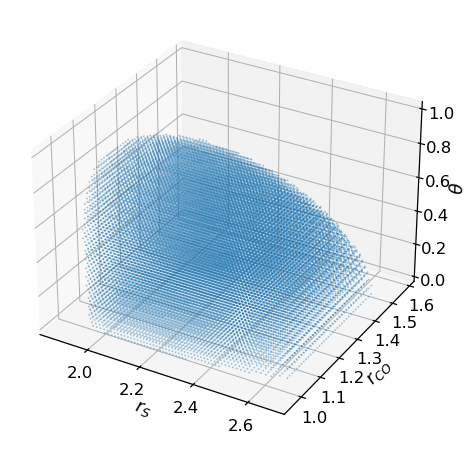

In [44]:
# plot grid points corresponding to the potential values lower than certain threshold
ind = np.where(V0 < 30000)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(*r_points[ind].T, s=1, alpha=0.3)
ax.set_xlabel("$r_{S}$")
ax.set_ylabel("$r_{CO}$")
ax.set_zlabel("$\\theta$")
plt.show()

The remaining quantities are products of basis functions $\Phi_l(x_p)=\phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)})$ and their derivatives $\partial\Phi_l(x_p)/\partial x_p.$

For this, we use `func_phi1`, `func_phi2`, and `func_phi3` as well as `func_dphi1`, `func_dphi2`, and `func_dphi3` functions defined earlier.

In [45]:
x1_, x2_, x3_ = x_points.T
q1, q2, q3 = quanta.T

psi = (
    func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3(x3_)[q3]
)  # shape = (no. bas. func., no. quad. points)

dpsi = np.array(
    [
        func_dphi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3(x3_)[q3],
        func_phi1(x1_)[q1] * func_dphi2(x2_)[q2] * func_phi3(x3_)[q3],
        func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_dphi3(x3_)[q3],
    ]
)  # shape = (3, no. bas. func., no. quad. points)

Now that all components have been precomputed, construct the matrix elements for both the potential and kinetic energy operators.

$$ V_{l',l}=\sum_p w_p \Phi_{l'}^*(x_p)V(f_{x\rightarrow r}(x_p)) \Phi_l(x_p),$$

$$
\frac{\partial\Phi_l(x_p)}{\partial r_\mu} =
\frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\nabla_x f_{x\rightarrow r}\right)^{-1},
$$

and

$$
T_{l',l}=\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\sum_p w_p
\frac{\partial\Phi_{l'}^*(x_p)}{\partial r_\lambda}
G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
\frac{\partial\Phi_l(x_p)}{\partial r_\mu}.
$$

In [46]:
pot0 = np.einsum("lp,mp,p,p->lm", psi, psi, V0, weights, optimize="optimal")
pot1 = np.einsum("lp,mp,p,p->lm", psi, psi, V1, weights, optimize="optimal")

dpsi_ = np.einsum("xlp,pxr->rlp", dpsi, jac_inv, optimize="optimal")
keo = 0.5 * np.einsum("rlp,smp,prs,p->lm", dpsi_, dpsi_, G, weights, optimize="optimal")

Diagonalise Hamiltonian matrix for different electronic states

In [47]:
h0 = keo + pot0
e0, v0 = np.linalg.eigh(h0)

h1 = keo + pot1
e1, v1 = np.linalg.eigh(h1)

Print state energies and state assignments

In [48]:
no_states = 20
for e, v, i in zip(e0, v0.T, range(no_states)):
    ind = np.argmax(np.abs(v))
    print(i, e - e0[0], np.abs(v[ind]) ** 2, quanta[ind])

0 0.0 0.08703846823681859 [0 0 7]
1 939.9348763667008 0.08913125577210365 [1 0 6]
2 1806.1575208361355 0.0777331106704933 [ 0  0 14]
3 1955.0482698751593 0.07256342226578322 [2 0 6]
4 2128.0231420708533 0.08580872488203532 [0 1 6]
5 2912.9119678081834 0.08183739572354345 [3 0 5]
6 3101.4284383446548 0.07969105995043656 [1 1 5]
7 3259.0983898908053 0.07315240151082064 [1 0 3]
8 4056.0406736787327 0.09764231458895897 [4 0 4]
9 4144.374069053355 0.07196642034742783 [2 1 5]
10 4231.191404571102 0.05870667343843526 [0 2 5]
11 4416.611691966859 0.06535297756215479 [0 1 3]
12 4738.418246089253 0.08438739850469691 [2 0 2]
13 5201.035373335498 0.0770123659030784 [0 0 9]
14 5301.159515791553 0.09142052921497577 [3 1 4]
15 5345.155542152604 0.08236018360710191 [1 2 5]
16 5374.938008600499 0.10283206543362074 [5 0 3]
17 5920.203322035596 0.08504400406949601 [1 1 2]
18 6456.177247717269 0.08582417443401623 [3 0 2]
19 6489.119370198825 0.0738839806792405 [0 3 4]


In [49]:
no_states = 20
for e, v, i in zip(e1, v1.T, range(no_states)):
    ind = np.argmax(np.abs(v))
    print(i, e - e1[0], np.abs(v[ind]) ** 2, quanta[ind])

0 0.0 0.13195118734461417 [0 0 1]
1 476.41377790721685 0.11258768596776297 [1 0 1]
2 833.0255085905476 0.14209903968682286 [ 0  0 10]
3 1014.123317370889 0.09027274066718514 [2 0 1]
4 1435.4136955522815 0.11500238444922853 [ 1  0 10]
5 1728.2261704142145 0.07528378337290242 [3 0 1]
6 1797.1296403949366 0.11387108133832277 [ 0  0 12]
7 1951.460718464699 0.09651278051778303 [0 1 4]
8 2306.73933549662 0.09703178849643537 [2 0 6]
9 2445.846646959799 0.10516977698734446 [1 1 1]
10 2583.1938831651205 0.07292065019276081 [6 0 1]
11 2846.2630648439417 0.07133348415702097 [ 0  1 10]
12 2874.0386058036083 0.07688109791704216 [ 1  0 12]
13 3125.6696984553546 0.1029429834427178 [2 1 1]
14 3227.9810023166665 0.09967207122725794 [3 0 6]
15 3367.4302456799433 0.0900503815755326 [ 0  0 14]
16 3593.3084814030926 0.07872419223071841 [5 0 1]
17 3688.961763657051 0.10516556041495065 [1 1 6]
18 3845.7964753655506 0.07185817825442081 [0 2 1]
19 3910.8337975503227 0.03935761291202704 [3 1 1]


## Contracted basis for bending coordinate

The Legendre basis set for the bending coordinate converges very slowly, primarily due to the range $[0,\pi]$
selected for the $\theta$ coordinate. The reason for this broad range for the angular coordinate is that
the potentials for different electronic excited states of OCS have minima at markedly different values
of the $\theta$ angle (see [ocs_potential.ipynb](ocs_potential.ipynb)).
To accommodate both states, the range for the $\theta$ angle must be broad.

The basis set for $\theta$ coordinate can be improved through _basis set contraction_ technique, which consists of two steps.
First, we define the wavefunction as linear combination of products of primitive basis functions for each coordinate,
where quatum numbers for all coordinates except the bending one are kept at zero, i.e.,
$$ \Phi_l^{(3)} = \sum_{k} c_{k}^{(l)}\phi_0^{(1)}(x_1)\phi_0^{(2)}(x_2)\phi_k^{(3)}(x_3),$$

and determine the expansion coefficients $c_{k}^{(l)}$ by solving the eigenvalue probelm
$$(\hat{T}+V)\Phi_l^{(3)} = E_l\Phi_l^{(3)}.$$

In the second step, we build the total wavefunction as usual, as sum of products of basis functions for different coordinates, where for $\theta$ coordinate instead of primitive functions $\phi_k^{(3)}(x_3)$ we use $\Phi_k^{(3)}(x_3)$ functions, i.e., 
$$ \Psi_l(x_1,x_2,x_3) = \sum_{i,j,k} c_{i,j,k}^{(l)}\phi_i^{(1)}(x_1)\phi_j^{(2)}(x_2)\Phi_k^{(3)}(x_3).$$

This approach significantly reduces the number of $k$ quantum numbers required in the combinations
of products compared to employing primitive functions $\phi_k^{(3)}(x_3)$, i.e., leads to a _faster basis-set convergence_.

This is demonstrated below.

In [22]:
# STEP 1

# freeze quantum numbers for stretches to 0
quanta1 = [0]
quanta2 = [0]
quanta3 = np.arange(0, Nb3)
Nmax = 40
weights_ijk = np.array([1, 1, 1])

quanta = np.array(
    [
        elem
        for elem in itertools.product(quanta1, quanta2, quanta3)
        if np.sum(elem * weights_ijk) <= Nmax
    ]
)  # shape = (no. basis funcs, 3)

# compute function and derivatives
x1_, x2_, x3_ = x_points.T
q1, q2, q3 = quanta.T

# compute product basis and derivatives
psi = func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3(x3_)[q3]
dpsi = np.array(
    [
        func_dphi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3(x3_)[q3],
        func_phi1(x1_)[q1] * func_dphi2(x2_)[q2] * func_phi3(x3_)[q3],
        func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_dphi3(x3_)[q3],
    ]
)

# compute matrix elements of potential and kinetic energy operators
pot0 = np.einsum("lp,mp,p,p->lm", psi, psi, V0, weights, optimize="optimal")
pot1 = np.einsum("lp,mp,p,p->lm", psi, psi, V1, weights, optimize="optimal")
dpsi_ = np.einsum("xlp,pxr->rlp", dpsi, jac_inv, optimize="optimal")
keo = 0.5 * np.einsum("rlp,smp,prs,p->lm", dpsi_, dpsi_, G, weights, optimize="optimal")

# diagonalise Hamiltonian for two electronic states
h0 = keo + pot0
e0, v0_contracted_coo_3 = np.linalg.eigh(h0)
h1 = keo + pot1
e1, v1_contracted_coo_3 = np.linalg.eigh(h1)

# redefine basis functions and derivatives for coordinate theta
# now, this function will depend on the electronic state

func_phi3_el0 = lambda x: np.dot(v0_contracted_coo_3.T, func_phi3(x))
func_dphi3_el0 = lambda x: np.dot(v0_contracted_coo_3.T, func_dphi3(x))

func_phi3_el1 = lambda x: np.dot(v1_contracted_coo_3.T, func_phi3(x))
func_dphi3_el1 = lambda x: np.dot(v1_contracted_coo_3.T, func_dphi3(x))

In [23]:
# STEP 2: repeat previous calculations where instead of `func_phi3` and `func_dphi3`
#   use `func_phi3_el0` and `func_dphi3_el0` for the ground electronic state
#   and `func_phi3_el1` and `func_dphi3_el1` for the excited electronic state

quanta1 = np.arange(0, Nb1)
quanta2 = np.arange(0, Nb2)
quanta3 = np.arange(0, Nb3)
Nmax = 20
weights_ijk = np.array([2, 2, 1])

quanta = np.array(
    [
        elem
        for elem in itertools.product(quanta1, quanta2, quanta3)
        if np.sum(elem * weights_ijk) <= Nmax
    ]
)  # shape = (no. basis funcs, 3)

# compute function and derivatives
x1_, x2_, x3_ = x_points.T
q1, q2, q3 = quanta.T

# compute product basis and derivatives
psi0 = func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3_el0(x3_)[q3]
psi1 = func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3_el1(x3_)[q3]
dpsi0 = np.array(
    [
        func_dphi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3_el0(x3_)[q3],
        func_phi1(x1_)[q1] * func_dphi2(x2_)[q2] * func_phi3_el0(x3_)[q3],
        func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_dphi3_el0(x3_)[q3],
    ]
)
dpsi1 = np.array(
    [
        func_dphi1(x1_)[q1] * func_phi2(x2_)[q2] * func_phi3_el1(x3_)[q3],
        func_phi1(x1_)[q1] * func_dphi2(x2_)[q2] * func_phi3_el1(x3_)[q3],
        func_phi1(x1_)[q1] * func_phi2(x2_)[q2] * func_dphi3_el1(x3_)[q3],
    ]
)

# compute matrix elements of potential and kinetic energy operators
pot0 = np.einsum("lp,mp,p,p->lm", psi0, psi0, V0, weights, optimize="optimal")
pot1 = np.einsum("lp,mp,p,p->lm", psi1, psi1, V1, weights, optimize="optimal")
dpsi0_ = np.einsum("xlp,pxr->rlp", dpsi0, jac_inv, optimize="optimal")
dpsi1_ = np.einsum("xlp,pxr->rlp", dpsi1, jac_inv, optimize="optimal")
keo0 = 0.5 * np.einsum("rlp,smp,prs,p->lm", dpsi0_, dpsi0_, G, weights, optimize="optimal")
keo1 = 0.5 * np.einsum("rlp,smp,prs,p->lm", dpsi1_, dpsi1_, G, weights, optimize="optimal")

# diagonalise Hamiltonian for two electronic states
h0 = keo0 + pot0
e0, v0 = np.linalg.eigh(h0)
h1 = keo1 + pot1
e1, v1 = np.linalg.eigh(h1)


In [24]:
no_states = 20
for e, v, i in zip(e0, v0.T, range(no_states)):
    ind = np.argmax(np.abs(v))
    print(i, e - e0[0], np.abs(v[ind]) ** 2, quanta[ind])

0 0.0 0.9572955817648217 [0 0 0]
1 860.5538466500432 0.8671428431049548 [1 0 0]
2 1044.5820371949192 0.9292617647293004 [0 0 1]
3 1716.3297057717543 0.7589355868732084 [2 0 0]
4 1894.408309523218 0.773740430345933 [1 0 1]
5 2042.7961433479015 0.8609341925697906 [0 1 0]
6 2109.925569202949 0.8622388549406995 [0 0 2]
7 2557.1229632308896 0.6262569566742675 [3 0 0]
8 2743.330300040294 0.6527336697117578 [2 0 1]
9 2908.0802154807116 0.7220815870106919 [1 1 0]
10 2976.1900344003197 0.7146893498705177 [1 0 2]
11 3083.8203361885944 0.8244313604483381 [0 1 1]
12 3385.300655184491 0.8501972405016656 [0 0 3]
13 3394.184079794951 0.4784124340319956 [4 0 0]
14 3574.6511608682404 0.5164121473566532 [3 0 1]
15 3770.8023185030124 0.5828582037690708 [2 1 0]
16 3822.4996661635732 0.5768968535706931 [2 0 2]
17 3938.1938595425936 0.6349931369469138 [1 1 1]
18 4060.5113062735845 0.6764159179838664 [0 2 0]
19 4146.132207244385 0.7637795629687741 [0 1 2]


In [25]:
no_states = 20
for e, v, i in zip(e1, v1.T, range(no_states)):
    ind = np.argmax(np.abs(v))
    print(i, e - e1[0], np.abs(v[ind]) ** 2, quanta[ind])

0 0.0 0.647680527368623 [0 0 0]
1 342.0865420073094 0.2885007812625524 [1 0 0]
2 612.5935339194084 0.52397026686741 [0 0 1]
3 712.6838076161091 0.12990640301950002 [1 0 1]
4 962.2044770218474 0.21968779660494173 [0 0 2]
5 1167.833806123225 0.123876041730255 [4 0 1]
6 1209.6025689183523 0.4640014788270217 [0 0 2]
7 1397.2901745882739 0.1580448738170497 [1 0 2]
8 1604.2985733291287 0.2553317016257992 [0 0 3]
9 1654.1686356559019 0.1463088434941288 [1 0 1]
10 1800.1038547754554 0.36288854885736255 [0 0 3]
11 1849.476743970339 0.4472374981433909 [0 1 0]
12 1873.4359849048499 0.17586718821921712 [2 0 0]
13 2059.8716754283096 0.12248393854234489 [2 0 0]
14 2187.1216984370067 0.1502099069057231 [1 0 2]
15 2213.8307954878555 0.2029155881225628 [1 1 0]
16 2231.851072552353 0.15478433440164446 [0 0 4]
17 2389.1356293644712 0.2870349319384573 [0 0 4]
18 2467.361364096034 0.3702728460679734 [0 1 1]
19 2484.5521873871367 0.1453000791197886 [1 0 4]


## Compute Franck-Condon transitions

Here, we will calculate the transitions between the vibrational states corresponding to different electronic states,
using Franck-Condon approximation ([Wiki page](https://en.wikipedia.org/wiki/Franck%E2%80%93Condon_principle))
$$ S(k',i'\leftarrow k,i)= \left|\langle \Psi_{k'}^{(i')}| \mu(i'\leftarrow i)|\Psi_{k}^{(i)}\rangle\right|^2\approx \left|\langle \Psi_{k'}^{(i')}|\Psi_{k}^{(i)}\rangle\right|^2.$$

In [50]:
# transform basis functions to the eigenfunction representation, i.e. solutions of vib. Schrödinger equation
psi0 = np.dot(v0.T, psi)
psi1 = np.dot(v1.T, psi)

# overlap between vibrational wavefunctions of diff. states
overlap = np.einsum("lp,kp,p->lk", psi0, psi1, weights, optimize="optimal")

# vibrational transition frequencies between diff. elec. states
elec_shift = (potentials[ind_elec1].e0 - potentials[ind_elec0].e0) * hartree_to_invcm
freq = np.abs(e0[:, None] - (e1[None, :] + elec_shift))

# energies of initial transition states
enr_ini = e0[:, None] * np.ones_like(e1)[None, :]

# indices of upper triangular part
ind = np.triu_indices(n=len(psi0), k=1, m=len(psi1))

# transition strengths, freqs., and ini-state energies
tran_str = np.abs(overlap[ind]) ** 2
freq = freq[ind]
enr_ini = enr_ini[ind]

Plot stick spectrum

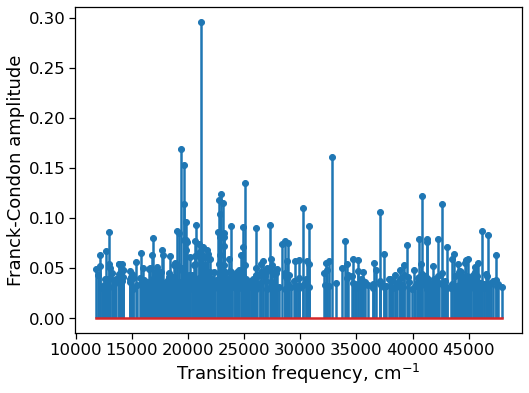

In [51]:
ind = np.where(tran_str >= np.max(tran_str) / 10)
plt.stem(freq[ind], tran_str[ind])
plt.xlabel("Transition frequency, cm$^{-1}$")
plt.ylabel("Franck-Condon amplitude")
plt.show()

Convolute with Lorentz profile

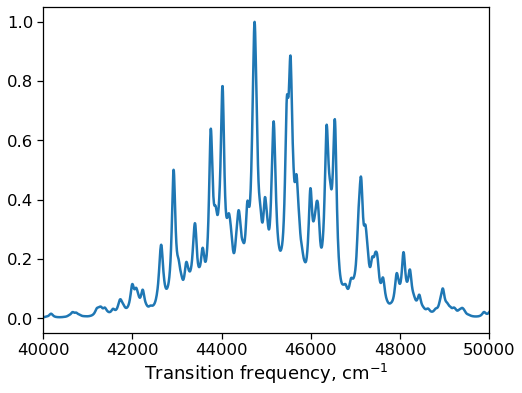

In [52]:
width = 100
temp = 170.0
kB = constants.value("Boltzmann constant in inverse meter per kelvin") / 100
Boltz = np.exp(-enr_ini / (kB * temp))
Boltz = Boltz / np.sum(Boltz)
points = np.linspace(np.min(freq), np.max(freq), 10000)


def convolute_lorentz(points, x, y, width):
    f = np.zeros(len(points))
    for i in range(len(x)):
        f += y[i] * 1 / np.pi * 0.5 * width / ((points - x[i]) ** 2 + 0.25 * width**2)
    return f


crossec = convolute_lorentz(points, freq, tran_str * Boltz, width)

plt.plot(points, crossec / np.max(crossec))
plt.xlabel("Transition frequency, cm$^{-1}$")
plt.xlim([40000, 50000])
plt.show()